In [196]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [197]:
g = 9.80665
m1 = 1
m2 = 1
L1 = 1
L2 = 1

def dydt(y, t):
    """
    time derivative of double pendulum dynamical system for integration
    Input: (4,) ndarray
    - th1, th2: derivative of first, second angles
    - om1, om2: derivative of first, second angular rates
    Output: (4,) ndarray
    - d_th1, d_th2: derivative of first, second angles
    - d_om1, d_om2: derivative of first, second angular rates
    """
    th1, th2, om1, om2 = y
    d_th1 = om1
    d_th2 = om2
    d_om1 = (-g*(2*m1+m2)*np.sin(th1)-m2*g*np.sin(th1-2*th2)-2*np.sin(th1-th2)*m2*(om2**2*L2+om1**2*L1*np.cos(th1-th2))) / (L1*(2*m1+m2-m2*np.cos(2*th1-2*th2)))
    d_om2 = (2*np.sin(th1-th2)*(om1**2*L1*(m1+m2)+g*(m1+m2)*np.cos(th1)+om2**2*L2*m2*np.cos(th1-th2))) / (L2*(2*m1+m2-m2*np.cos(2*th1-2*th2)))
    return np.array([d_th1, d_th2, d_om1, d_om2])

def get_data(th1_0, th2_0, om1_0, om2_0, t0, tf, dt):
    """
    generate data for double pendulum system
    Input:
    - th1_0, th2_0: initial angles
    - om1_0, om2_0: initial angular rates
    - t0, tf: initial, final time
    - dt: time step
    Output:
    - t: (N,) ndarray
    - th1, th2: (N,) ndarray
    - om1, om2: (N,) ndarray
    """
    t = np.arange(t0, tf, dt)
    y0 = np.array([th1_0, th2_0, om1_0, om2_0])
    y = sci.odeint(dydt, y0, t)
    th1, th2, om1, om2 = y.T
    return t, th1, th2, om1, om2

def get_data_batch(th1_0, th2_0, om1_0, om2_0, t0, tf, dt):
    """
    generate a batch of data for double pendulum system.
    integrated independently for each trajectory.
    Input:
    - th1_0, th2_0: (N, batch_size) ndarray
    - om1_0, om2_0: (N, batch_size) ndarray
    - t0, tf: initial, final time
    - dt: time step
    - batch_size: number of trajectories
    Output:
    - t: (N,batch_size) ndarray
    - th1, th2: (N,batch_size) ndarray
    - om1, om2: (N,batch_size) ndarray
    """
    th1s = []
    th2s = []
    om1s = []
    om2s = []
    for i in range(th1_0.shape[1]):
        t, th1, th2, om1, om2 = get_data(th1_0[0,i], th2_0[0,i], om1_0[0,i], om2_0[0,i], t0, tf, dt)
        th1s.append(th1)
        th2s.append(th2)
        om1s.append(om1)
        om2s.append(om2)
    th1s = np.array(th1s)
    th2s = np.array(th2s)
    om1s = np.array(om1s)
    om2s = np.array(om2s)
    return t, th1s.T, th2s.T, om1s.T, om2s.T

def get_data_batch_noise(th1_0, th2_0, om1_0, om2_0, t0, tf, dt, noise):
    """
    generate a batch of noisy data for double pendulum system.
    integrated independently for each trajectory.
    Input:
    - th1_0, th2_0: initial angles
    - om1_0, om2_0: initial angular rates
    - t0, tf: initial, final time
    - dt: time step
    - batch_size: number of trajectories
    - noise: standard deviation of noise
    Output:
    - t: (N,batch_size) ndarray
    - th1, th2: (N,batch_size) ndarray
    - om1, om2: (N,batch_size) ndarray
    """
    th1s = []
    th2s = []
    om1s = []
    om2s = []
    for i in range(th1_0.shape[1]):
        t, th1, th2, om1, om2 = get_data(th1_0[0,i], th2_0[0,i], om1_0[0,i], om2_0[0,i], t0, tf, dt)
        th1s.append(th1)
        th2s.append(th2)
        om1s.append(om1)
        om2s.append(om2)
    th1s = np.array(th1s)
    th2s = np.array(th2s)
    om1s = np.array(om1s)
    om2s = np.array(om2s)
    th1s += np.random.normal(0, noise, th1s.shape)
    th2s += np.random.normal(0, noise, th2s.shape)
    om1s += np.random.normal(0, noise, om1s.shape)
    om2s += np.random.normal(0, noise, om2s.shape)
    return t, th1s.T, th2s.T, om1s.T, om2s.T

def energy(th1, th2, om1, om2):
    """
    compute energy of double pendulum system
    Input:
    - th1, th2: (N,) or (N,batch_size) ndarray
    - om1, om2: (N,) or (N,batch_size) ndarray
    Output:
    - E: (N,) or (N,batch_size) ndarray
    """
    E = 0.5*m1*(L1**2)*(om1**2) + 0.5*m2*((L1**2)*(om1**2) + (L2**2)*(om2**2) + 2*L1*L2*om1*om2*np.cos(th1-th2)) - m1*g*L1*np.cos(th1) - m2*g*(L1*np.cos(th1) + L2*np.cos(th2))
    return E

def animate(t, dt, th1, th2, title='double pendulum'):
    """
    animate double pendulum system
    Input:
    - t: (N,) ndarray
    - th1, th2: (N,) ndarray
    Output:
    - animation
    """
    if len(th1.shape) != 1:
        raise ValueError('th1 must be 1D array')
    fig = plt.figure()
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
    ax.set_aspect('equal')
    ax.grid()
    ax.set_title(title) 
    line, = ax.plot([], [], 'o-', lw=2)
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    def init():
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text
    def update(i):
        x = [0, L1*np.sin(th1[i]), L1*np.sin(th1[i]) + L2*np.sin(th2[i])]
        y = [0, -L1*np.cos(th1[i]), -L1*np.cos(th1[i]) - L2*np.cos(th2[i])]
        line.set_data(x, y)
        time_text.set_text(time_template % (i*dt))
        return line, time_text
    ani = animation.FuncAnimation(fig, update, range(1, len(t)),
                                  interval=dt*1000, blit=True, init_func=init)
    return ani

def animate_batch(t, dt, th1, th2, title='double pendulum'):
    """
    animate double pendulum system
    Input:
    - t: (N,) ndarray
    - th1, th2: (N,batch_size) ndarray
    Output:
    - animation
    """
    if len(th1.shape) != 2:
        raise ValueError('th1 and th2 must be (N,batch_size) ndarray')
    fig = plt.figure()
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
    ax.set_aspect('equal')
    ax.grid()
    ax.set_title(title)
    lines = []
    for i in range(th1.shape[1]):
        line, = ax.plot([], [], 'o-', lw=2)
        lines.append(line)
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    def init():
        for line in lines:
            line.set_data([], [])
        time_text.set_text('')
        return *lines, time_text
    def update(i):
        for line, th1_ani, th2_ani in zip(lines, th1.T, th2.T):
            x = [0, L1*np.sin(th1_ani[i]), L1*np.sin(th1_ani[i]) + L2*np.sin(th2_ani[i])]
            y = [0, -L1*np.cos(th1_ani[i]), -L1*np.cos(th1_ani[i]) - L2*np.cos(th2_ani[i])]
            line.set_data(x, y)
        time_text.set_text(time_template % (i*dt))
        return *lines, time_text
    ani = animation.FuncAnimation(fig, update, range(1, len(t)),
                                  interval=dt*1000, blit=True, init_func=init)
    return ani

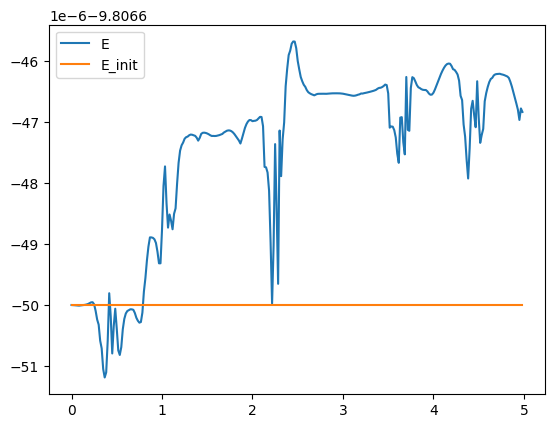

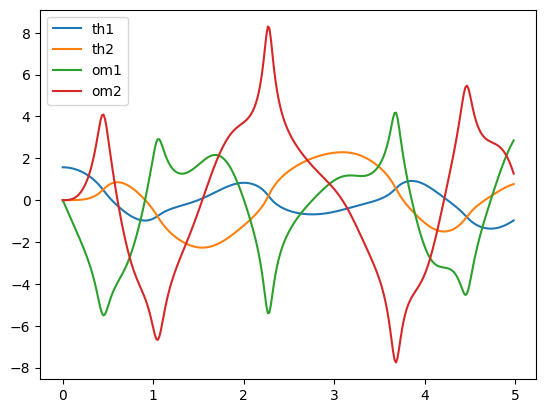

In [200]:
th1_0 = np.pi/2
th2_0 = 0
om1_0 = 0
om2_0 = 0
t0 = 0
tf = 5
dt = 1/60
t, th1, th2, om1, om2 = get_data(th1_0, th2_0, om1_0, om2_0, t0, tf, dt)
E = energy(th1, th2, om1, om2)
E_init = E[0]
plt.plot(t, E, label='E')
plt.plot(t, np.ones(t.shape)*E_init, label='E_init')
plt.legend()
plt.show()
plt.plot(t, th1, label='th1')
plt.plot(t, th2, label='th2')
plt.plot(t, om1, label='om1')
plt.plot(t, om2, label='om2')
plt.legend()
plt.show()

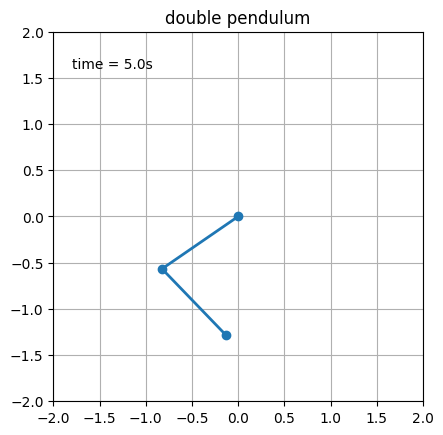

In [201]:
ani = animate(t, dt, th1, th2)
HTML(ani.to_html5_video())

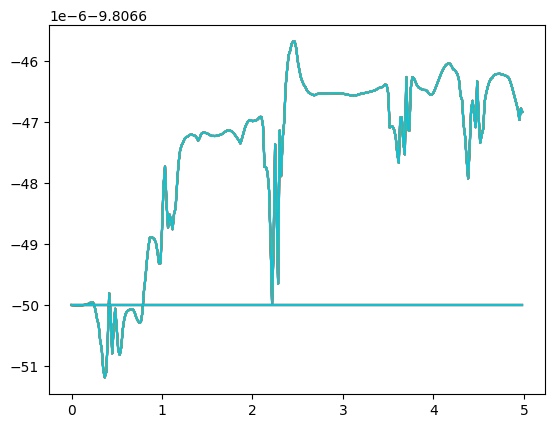

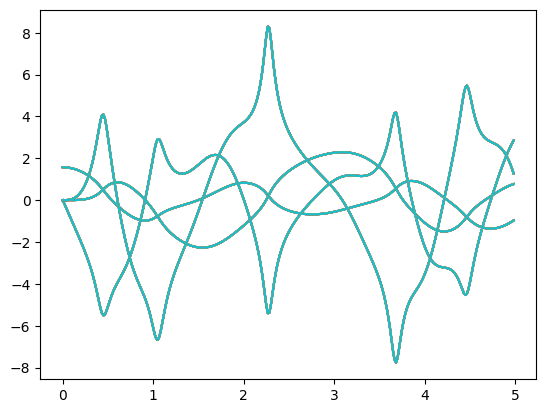

In [202]:
batch_size = 10
th1_0 = np.pi/2 * np.ones((1,batch_size))
th2_0 = 0 * np.ones((1,batch_size))
om1_0 = 0 * np.ones((1,batch_size))
om2_0 = 0 * np.ones((1,batch_size))
t0 = 0
tf = 5
dt = 1/60
t, th1, th2, om1, om2 = get_data_batch(th1_0, th2_0, om1_0, om2_0, t0, tf, dt)
E = energy(th1, th2, om1, om2)
E_init = E[0]
plt.plot(t, E, label='E')
plt.plot(t, np.ones((t.size,1))*np.reshape(E_init, (1,-1)), label='E_init')
plt.show()
plt.plot(t, th1, label='th1')
plt.plot(t, th2, label='th2')
plt.plot(t, om1, label='om1')
plt.plot(t, om2, label='om2')
plt.show()

(300, 10)


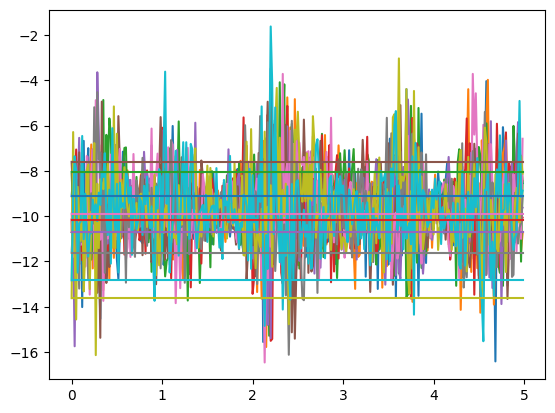

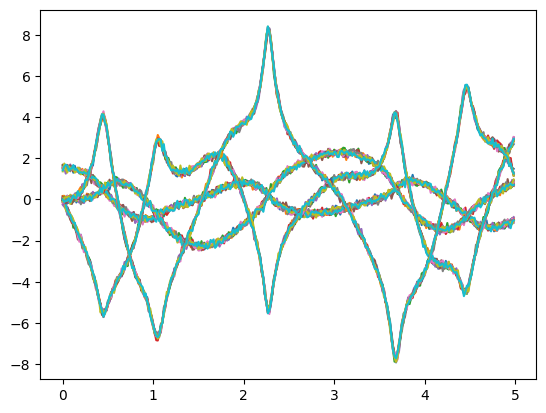

In [203]:
batch_size = 10
th1_0 = np.pi/2 * np.ones((1,batch_size))
th2_0 = 0 * np.ones((1,batch_size))
om1_0 = 0 * np.ones((1,batch_size))
om2_0 = 0 * np.ones((1,batch_size))
t0 = 0
tf = 5
dt = 1/60
noise = 0.1
t, th1, th2, om1, om2 = get_data_batch_noise(th1_0, th2_0, om1_0, om2_0, t0, tf, dt, noise)
E = energy(th1, th2, om1, om2)
E_init = E[0]
print(th1.shape)
plt.plot(t, E, label='E')
plt.plot(t, np.ones((t.size,1))*np.reshape(E_init, (1,-1)), label='E_init')
plt.show()
plt.plot(t, th1, label='th1')
plt.plot(t, th2, label='th2')
plt.plot(t, om1, label='om1')
plt.plot(t, om2, label='om2')
plt.show()

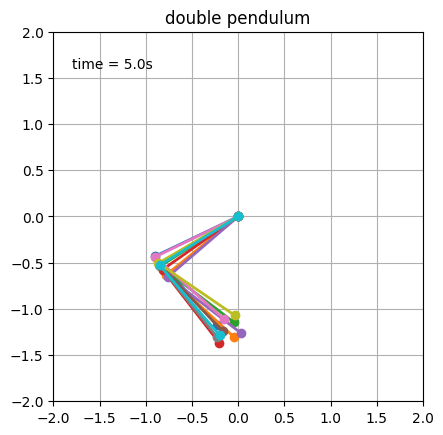

In [204]:
ani = animate_batch(t, dt, th1, th2)
HTML(ani.to_html5_video())

In [205]:
def predict_linear(dt, dt_int, th1, th2, om1, om2):
    """
    Prediction step function for use in kalman filter.
    Uses instantaneous linearized dynamics.
    dt_int unused for compatibility with predict_nonlinear.
    """
    th1_pred = th1 + dt*om1
    th2_pred = th2 + dt*om2
    return th1_pred, th2_pred

def predict_nonlinear(dt, dt_int, th1, th2, om1, om2):
    """
    Prediction step function for use in kalman filter.
    Uses integration of nonlinear dynamics.
    """
    if len(th1.shape) == 1:
        t, th1_pred, th2_pred, _, _ = get_data(th1, th2, om1, om2, 0, dt+dt_int/100, dt_int)
        return th1_pred[-1], th2_pred[-1]
    else:
        t, th1_pred, th2_pred, _, _ = get_data_batch(th1, th2, om1, om2, 0, dt+dt_int/100, dt_int)
        return th1_pred[-1,:], th2_pred[-1,:]

def kalman_filter(t, th1, th2, om1, om2, Q, R, predict=predict_linear, int_factor=60):
    """
    Emulates kalman filter for double pendulum system
    Uses linearized dynamics for prediction step
    Input:
    - t: (N,) ndarray
    - th1, th2: (N,) ndarray
    - om1, om2: (N,) ndarray
    - Q: (4,) ndarray (process noise covariance)
    - R: (4,) ndarray (measurement noise covariance)
    - predict: function (default: predict_linear)
    - int_factor: int (default: 60)
    Output:
    - th1_kf, th2_kf: (N,) ndarray
    """
    if len(th1.shape) != 1:
        raise ValueError('th1 and th2 must be (N,) ndarray')
    if len(th2.shape) != 1:
        raise ValueError('th1 and th2 must be (N,) ndarray')
    if len(om1.shape) != 1:
        raise ValueError('om1 and om2 must be (N,) ndarray')
    if len(om2.shape) != 1:
        raise ValueError('om1 and om2 must be (N,) ndarray')
    
    # Initialize
    P = np.zeros((4,4)) # Initial state covariance
    th1_kf = np.zeros(th1.shape)
    th2_kf = np.zeros(th2.shape)
    th1_kf[0] = th1[0]
    th2_kf[0] = th2[0]
    for i in range(1, t.size):
        # Prediction step
        dt = t[i] - t[i-1]
        dt_int = dt/int_factor
        th1_pred, th2_pred = predict(dt, dt_int, th1_kf[i-1], th2_kf[i-1], om1[i-1], om2[i-1])
        P_pred = P + Q
        # Update step
        K = P_pred @ np.linalg.inv(P_pred + R)
        th1_kf[i] = th1_pred + K[0,0]*(th1[i] - th1_pred) + K[0,1]*(th2[i] - th2_pred)
        th2_kf[i] = th2_pred + K[1,0]*(th1[i] - th1_pred) + K[1,1]*(th2[i] - th2_pred)
        P = (np.eye(4) - K) @ P_pred
        
    return th1_kf, th2_kf

def kalman_filter_batch(t, th1, th2, om1, om2, Q, R, predict=predict_linear, int_factor=60):
    """
    Emulates kalman filter for a batched double pendulum system
    Uses linearized dynamics for prediction step
    Input:
    - t: (N,) ndarray
    - th1, th2: (N,batch_size) ndarray
    - om1, om2: (N,batch_size) ndarray
    - Q: (4,) ndarray (process noise covariance)
    - R: (4,) ndarray (measurement noise covariance)
    - predict: function (default: predict_linear)
    - int_factor: int (default: 60)
    Output:
    - th1_kf, th2_kf: (N,batch_size) ndarray
    """
    if len(th1.shape) != 2:
        raise ValueError('th1 and th2 must be (N,batch_size) ndarray')
    if len(th2.shape) != 2:
        raise ValueError('th1 and th2 must be (N,batch_size) ndarray')
    if len(om1.shape) != 2:
        raise ValueError('om1 and om2 must be (N,batch_size) ndarray')
    if len(om2.shape) != 2:
        raise ValueError('om1 and om2 must be (N,batch_size) ndarray')
    
    # Initialize
    P = np.zeros((4,4)) # Initial state covariance
    th1_kf = np.zeros(th1.shape)
    th2_kf = np.zeros(th2.shape)
    th1_kf[0,:] = th1[0,:]
    th2_kf[0,:] = th2[0,:]
    for i in range(1, t.size):
        # Prediction step
        dt = t[i] - t[i-1]
        dt_int = dt/int_factor
        th1_pred, th2_pred = predict(dt, dt_int, th1_kf[i-1:i,:], th2_kf[i-1:i,:], om1[i-1:i,:], om2[i-1:i,:]) # Preserve 2D shape in splicing
        P_pred = P + Q
        # Update step
        K = P_pred @ np.linalg.inv(P_pred + R)
        th1_kf[i,:] = th1_pred + K[0,0]*(th1[i,:] - th1_pred) + K[0,1]*(th2[i,:] - th2_pred)
        th2_kf[i,:] = th2_pred + K[1,0]*(th1[i,:] - th1_pred) + K[1,1]*(th2[i,:] - th2_pred)
        P = (np.eye(4) - K) @ P_pred

    return th1_kf, th2_kf

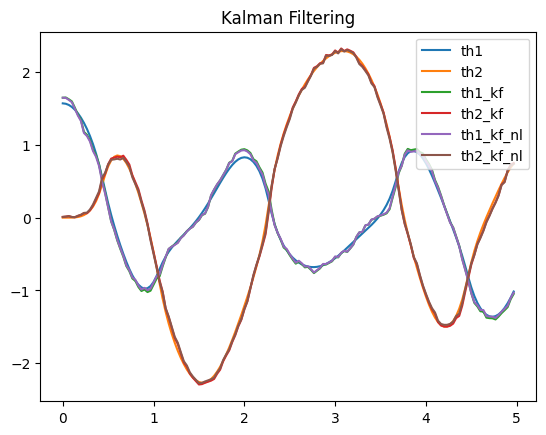

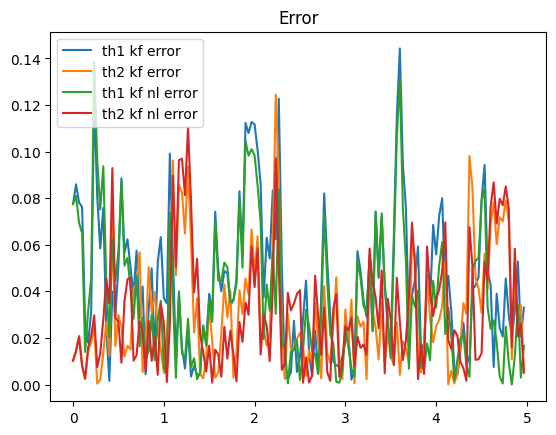

Kf error:  0.05807108902856586
Kf nl error:  0.05428168487794079


In [212]:
batch_size = 1
th1_0 = np.pi/2 * np.ones((1,batch_size))
th2_0 = 0 * np.ones((1,batch_size))
om1_0 = 0 * np.ones((1,batch_size))
om2_0 = 0 * np.ones((1,batch_size))
t0 = 0
tf = 5
dt = 1/60
noise = 0.1
t, th1, th2, om1, om2 = get_data_batch(th1_0, th2_0, om1_0, om2_0, t0, tf, dt)
t, th1_noisy, th2_noisy, om1_noisy, om2_noisy = get_data_batch_noise(th1_0, th2_0, om1_0, om2_0, t0, tf, dt, noise)
plt.plot(t, th1, label='th1')
plt.plot(t, th2, label='th2')

Q = np.diag([0.01, 0.01, 0.01, 0.01])
R = np.eye(4)*noise
th1_kf, th2_kf = kalman_filter_batch(t, th1_noisy, th2_noisy, om1_noisy, om2_noisy, Q, R)
plt.plot(t, th1_kf, label='th1_kf')
plt.plot(t, th2_kf, label='th2_kf')

th1_kf_nl, th2_kf_nl = kalman_filter_batch(t, th1_noisy, th2_noisy, om1_noisy, om2_noisy, Q, R, predict=predict_nonlinear)
plt.plot(t, th1_kf_nl, label='th1_kf_nl')
plt.plot(t, th2_kf_nl, label='th2_kf_nl')
plt.title('Kalman Filtering')
plt.legend()
plt.show()

plt.plot(t, abs(th1 - th1_kf), label='th1 kf error')
plt.plot(t, abs(th2 - th2_kf), label='th2 kf error')
plt.plot(t, abs(th1 - th1_kf_nl), label='th1 kf nl error')
plt.plot(t, abs(th2 - th2_kf_nl), label='th2 kf nl error')
plt.title('Error')
plt.legend()
plt.show()

kf_err = np.mean(np.sqrt((th1 - th1_kf)**2 + (th2 - th2_kf)**2))
kf_nl_err = np.mean(np.sqrt((th1 - th1_kf_nl)**2 + (th2 - th2_kf_nl)**2))
print("Kf error: ", kf_err)
print("Kf nl error: ", kf_nl_err)

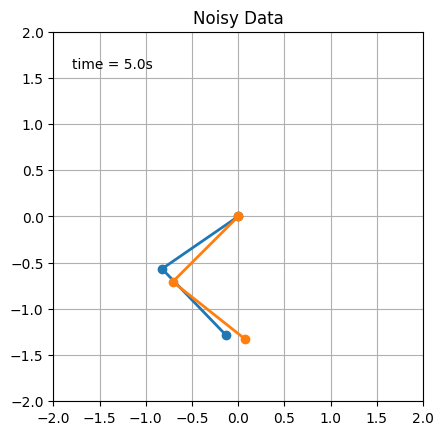

In [207]:
th1_ani = np.hstack((th1, th1_noisy))
th2_ani = np.hstack((th2, th2_noisy))
ani_noisy = animate_batch(t, dt, th1_ani, th2_ani, title='Noisy Data')
HTML(ani_noisy.to_html5_video())

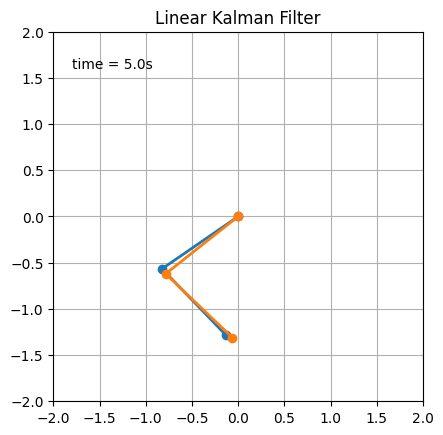

In [208]:
th1_ani = np.hstack((th1, th1_kf))
th2_ani = np.hstack((th2, th2_kf))
ani_kf = animate_batch(t, dt, th1_ani, th2_ani, title='Linear Kalman Filter')
HTML(ani_kf.to_html5_video())

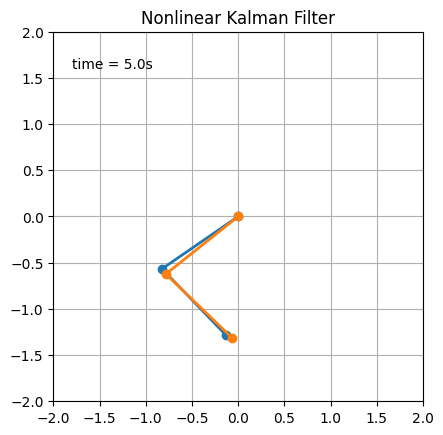

In [209]:
th1_ani = np.hstack((th1, th1_kf_nl))
th2_ani = np.hstack((th2, th2_kf_nl))
ani_kf_nl = animate_batch(t, dt, th1_ani, th2_ani, title='Nonlinear Kalman Filter')
HTML(ani_kf_nl.to_html5_video())